In [2]:
!pip install super-gradients
!pip install imutils
!pip install pytube --upgrade

In [5]:
import torch
torch.__version__

'2.1.2'

In [6]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
import os
os.makedirs('/kaggle/working/shoplifting_checkpoints')

In [11]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/kaggle/working/shoplifting_checkpoints'
trainer = Trainer(experiment_name = 'shoplifting_1', ckpt_root_dir= CHECKPOINT_DIR)

# Loading The Data

In [12]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [14]:
dataset_params = {
    'data_dir':'/kaggle/input/shoplifting-dataset-3',
    'train_images_dir':'/kaggle/input/shoplifting-dataset-3/train/images',
    'train_labels_dir':'/kaggle/input/shoplifting-dataset-3/train/labels',
    'val_images_dir':'/kaggle/input/shoplifting-dataset-3/valid/images',
    'val_labels_dir':'/kaggle/input/shoplifting-dataset-3/valid/labels',
    'test_images_dir':'/kaggle/input/shoplifting-dataset-3/test/images',
    'test_labels_dir':'/kaggle/input/shoplifting-dataset-3/test/labels',
    'classes':['normal', 'shoplifting']
    }

In [16]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params = {
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)


[2024-02-29 15:34:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 3717/3717 [00:10<00:00, 351.01it/s]
[2024-02-29 15:34:25] WARNING - detection_dataset.py - Found 753 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-02-29 15:34:26] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 918/918 [00:02<00:00, 349.57it/s]
[2024-02-29 15:34:28] WARNING - detection_dataset.py - Found 331 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-02-29 15:34:28] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset ind

# Instantiate The Model

In [18]:
from super_gradients.training import models

model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco")

[2024-02-29 15:34:43] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-29 15:34:43] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


# Defining The Training Parameters

In [19]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Training the model

In [20]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-02-29 15:34:52] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240229_153452_599147`
[2024-02-29 15:34:52] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/shoplifting_checkpoins/shoplifting_1/RUN_20240229_153452_599147
[2024-02-29 15:34:52] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /kaggle/working/shoplifting_checkpoins/shoplifting_1/RUN_20240229_153452_599147/console_Feb29_15_34_52.txt


/opt/conda/lib/python3.10/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/opt/conda/lib/python3.10/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-02-29 15:34:56] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Full dataset size:

# Get the best model

In [23]:
from super_gradients.training import models

best_model = models.get('yolo_nas_s',
                       num_classes = len(dataset_params['classes']),
                       checkpoint_path = "/kaggle/working/shoplifting_checkpoints/shoplifting_1/RUN_20240229_153452_599147/ckpt_best.pth")

[2024-02-29 16:51:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/shoplifting_checkpoins/shoplifting_1/RUN_20240229_153452_599147/ckpt_best.pth EMA checkpoint.


# Evaluating The Best Trained Model

In [24]:
trainer.test(model=best_model,
             test_loader = test_data,
             test_metrics_list = DetectionMetrics_050(score_thres = 0.1,
                                                      top_k_predictions = 300,
                                                      num_cls = len(dataset_params['classes']),
                                                      normalize_targets = True,
                                                      post_prediction_callback = PPYoloEPostPredictionCallback(score_threshold = 0.01,
                                                                                                               nms_top_k = 1000,
                                                                                                               max_predictions = 300,
                                                                                                               nms_threshold = 0.7)))

Testing:  96%|█████████▌| 25/26 [00:10<00:00,  2.67it/s]

{'PPYoloELoss/loss_cls': 1.1595685,
 'PPYoloELoss/loss_iou': 0.53890216,
 'PPYoloELoss/loss_dfl': 0.661899,
 'PPYoloELoss/loss': 2.3603697,
 'Precision@0.50': 0.0229448601603508,
 'Recall@0.50': 0.9081728458404541,
 'mAP@0.50': 0.568567156791687,
 'F1@0.50': 0.0447578988969326,
 'Best_score_threshold': 0.4399999976158142}

Testing: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]


# Predictions

In [31]:
os.makedirs('/kaggle/working/testing_outputs')

[2024-02-29 17:15:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


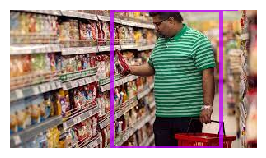

In [39]:
test_image = '/kaggle/input/training-dataset/test_image_1.jfif'
model.predict(test_image).show()

In [32]:
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = "/kaggle/input/testing-images/istockphoto-1328141050-640_adpp_is.mp4"
output_video_path = "/kaggle/working/testing_outputs/detections.mp4"

best_model.to(device).predict(input_video_path).save(output_video_path)

Processing Video: 100%|██████████| 616/616 [00:11<00:00, 55.32it/s]
